In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'az-handwritten-alphabets-in-csv-format:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F9726%2F17999%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240307%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240307T173033Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D44a7d2bd6e647a66703df9d811b4ae99eb3219da2d82d367581cf9a2e2cc2fb8fbee42b0afad80949b2d3b1a9b739a9f389834cb523067a8b3ae655854032e34c1e268abf49768facda94e4963517bb552642a3fffaea15547f4eea32c85d76aba1289a6e605a8e7bcad9df16665a1def0e11985a9ede15ed6402fb4050c0414792559775133c911885527e0358590d21ac338682ac6e780996c5e788823fec4e93d21811e85b0b9bfc758397b3616d3c0ff7558048e479bf373bbcb373d8f689e7f544d54c069d1136516ec1b6a963d376a48665c161f50f131beb3f02a50e838c24c80c512efbef0b04e220baf6e18da25c2bc1b91fa75af0f85791cbf80fb,mnist-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F102285%2F242592%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240307%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240307T173033Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D129dbfbd4c6598ab5c22a21065a956aefdc70eec4af655ae900f8c8908c9d418a163eac3449b68a3820543945203896dcb1cbcbca1e52a34333818386bd567c4f4007e4a311f0fe7635521922ede0e987d5af85b0cddc4c7fa73fde1a5f29b3ec6ee5024b774550830dc5004419d146cf0b7425fa85fbe14e208fdc7f4f336196c4587245ba4223030e23517c99be72070d783bf714c71902e1ee40fa9c8b3988b4e85adeec3160f9631c3c834345cf995cd21f493fe1bfe02e2f8ecb47c31ae521031ed0e509e62e9043709e39cadff5fb38db0629845115f38a78c828e19f4d20e240020a428205045789c62f07f67e29472cf6969596411db09934cb6d294,customclasses:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4464838%2F7786361%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240307%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240307T173034Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8c6e93c598929773259dff3c62fdd3e4d5ad860c3e415c6b8bf39a482bf3b9f7774384a0c6f3af31d8b950d7ad21149291c90ab1cdc77b121831457df7982ce63e70e4845af417c2496d35f1f98dbf888e5fc08dfb6e90b7ee93aa21ed14b99d7cb8bb8210aa0641043fc718a82f517e9731f937515cf428d7596188b7aec7c793a845ce5fc5efb512c2f9d2396bef69e124edc4cbf8d512d8170baaf50ef3012cdbdf2ebd50700547140520426dca4a6d410dae5ca0024f42eec3469a96237480565cb91d6166933bc7b18f3a2fdfd6207ddc1b8d44273475439e422f5d1ea0a29d3894f847a2c52b8016c1509110175398d685db328a1e320c996b2c95d82e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 193643888 bytes downloaded
Downloaded and uncompressed: az-handwritten-alphabets-in-csv-format
[==================================================] 23112702 bytes downloaded
Downloaded and uncompressed: mnist-dataset
[==================================================] 10374 bytes downloaded
Downloaded and uncompressed: customclasses
Data source import complete.


## Variational AutoEncoder (VAE) - MNIST data
From [Keras-Team, author-fchollet (github)](https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py) or step-by-step explanation on [Keras documentation-examples](https://keras.io/examples/generative/vae/).

In [2]:
import re, os, random

# Add paths to custom modules
custom_files = 'customclasses'
custom_dir = os.path.join('/kaggle/input', custom_files)
if custom_dir not in os.sys.path:
    os.sys.path.insert(0, custom_dir)


# Import all custom variables and modules
from preprocessing import *
from vae2 import *

TRAIN_MODEL = True
RND_STATE = 247
ARCH_NN = 'vae' # 'autoencoder','vae', 'gan', 'vq-vae'
tf.keras.utils.set_random_seed(RND_STATE)

### 1. Upload training data

In [3]:
# Load Hand-written alphabet images
if 'letters' not in dir():
    letters = MNIST_letters(
        '/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv'
    )

# Preprocessing and normalization
(x_train, y_train), (x_test, y_test) = \
    letters.split_data(train_ratio=0.5, random_state=RND_STATE)

mnist_letters = letters.normalize(x_train)
print("Shape of MNIST dataset: {}\nShape of training data: {}"
      .format(str(letters.df.shape),str(mnist_letters.shape)))

Shape of MNIST dataset: (144013, 784)
Shape of training data: (72006, 28, 28, 1)


### 2. Build the model (VAE)

In [4]:
model = AE_variational(in_shape=mnist_letters.shape[1:], panel_size=[32,64], latent_dim=32)
model.encoder.summary()
model.decoder.summary()
#tf.keras.utils.plot_model(model.encoder, show_shapes=True, show_layer_activations=True)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 Conv2D_1 (Conv2D)           (None, 28, 28, 32)           320       ['inputs[0][0]']              
                                                                                                  
 encode_1 (MaxPooling2D)     (None, 14, 14, 32)           0         ['Conv2D_1[0][0]']            
                                                                                                  
 Conv2D_0 (Conv2D)           (None, 14, 14, 64)           18496     ['encode_1[0][0]']            
                                                                                            

### 3. Train the VAE

In [5]:
callback = keras.callbacks.EarlyStopping(
    monitor="val_reconstruction_loss",
    patience=10,
    verbose=1,
    restore_best_weights=True
)

model.compile(optimizer=keras.optimizers.Adam())
if TRAIN_MODEL:
    history = model.fit(
        mnist_letters,
        mnist_letters,
        epochs=100,
        batch_size=128,
        callbacks=[callback],
        validation_split=0.2,
        verbose=0
    )
    # model.save('model.keras')
    model.save_weights('/kaggle/working/checkpoints/last_checkpoint')
else:
    # model = keras.models.load_model('model.keras')
    model.load_weights('/kaggle/working/checkpoints/last_checkpoint')


Restoring model weights from the end of the best epoch: 87.
Epoch 97: early stopping


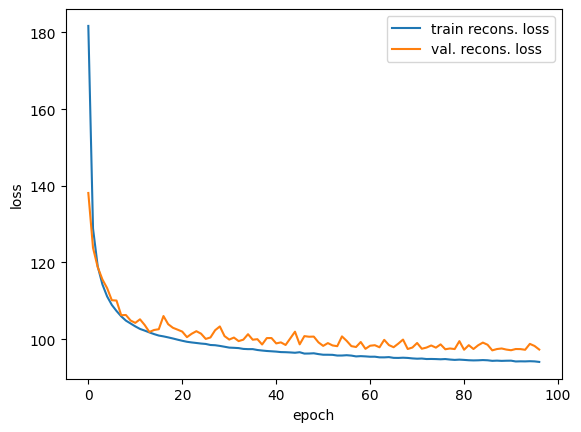

In [6]:
# plot history
if TRAIN_MODEL:
    plt.plot(history.history['reconstruction_loss'], label='train recons. loss')
    plt.plot(history.history['val_reconstruction_loss'], label='val. recons. loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

### VAE predictions

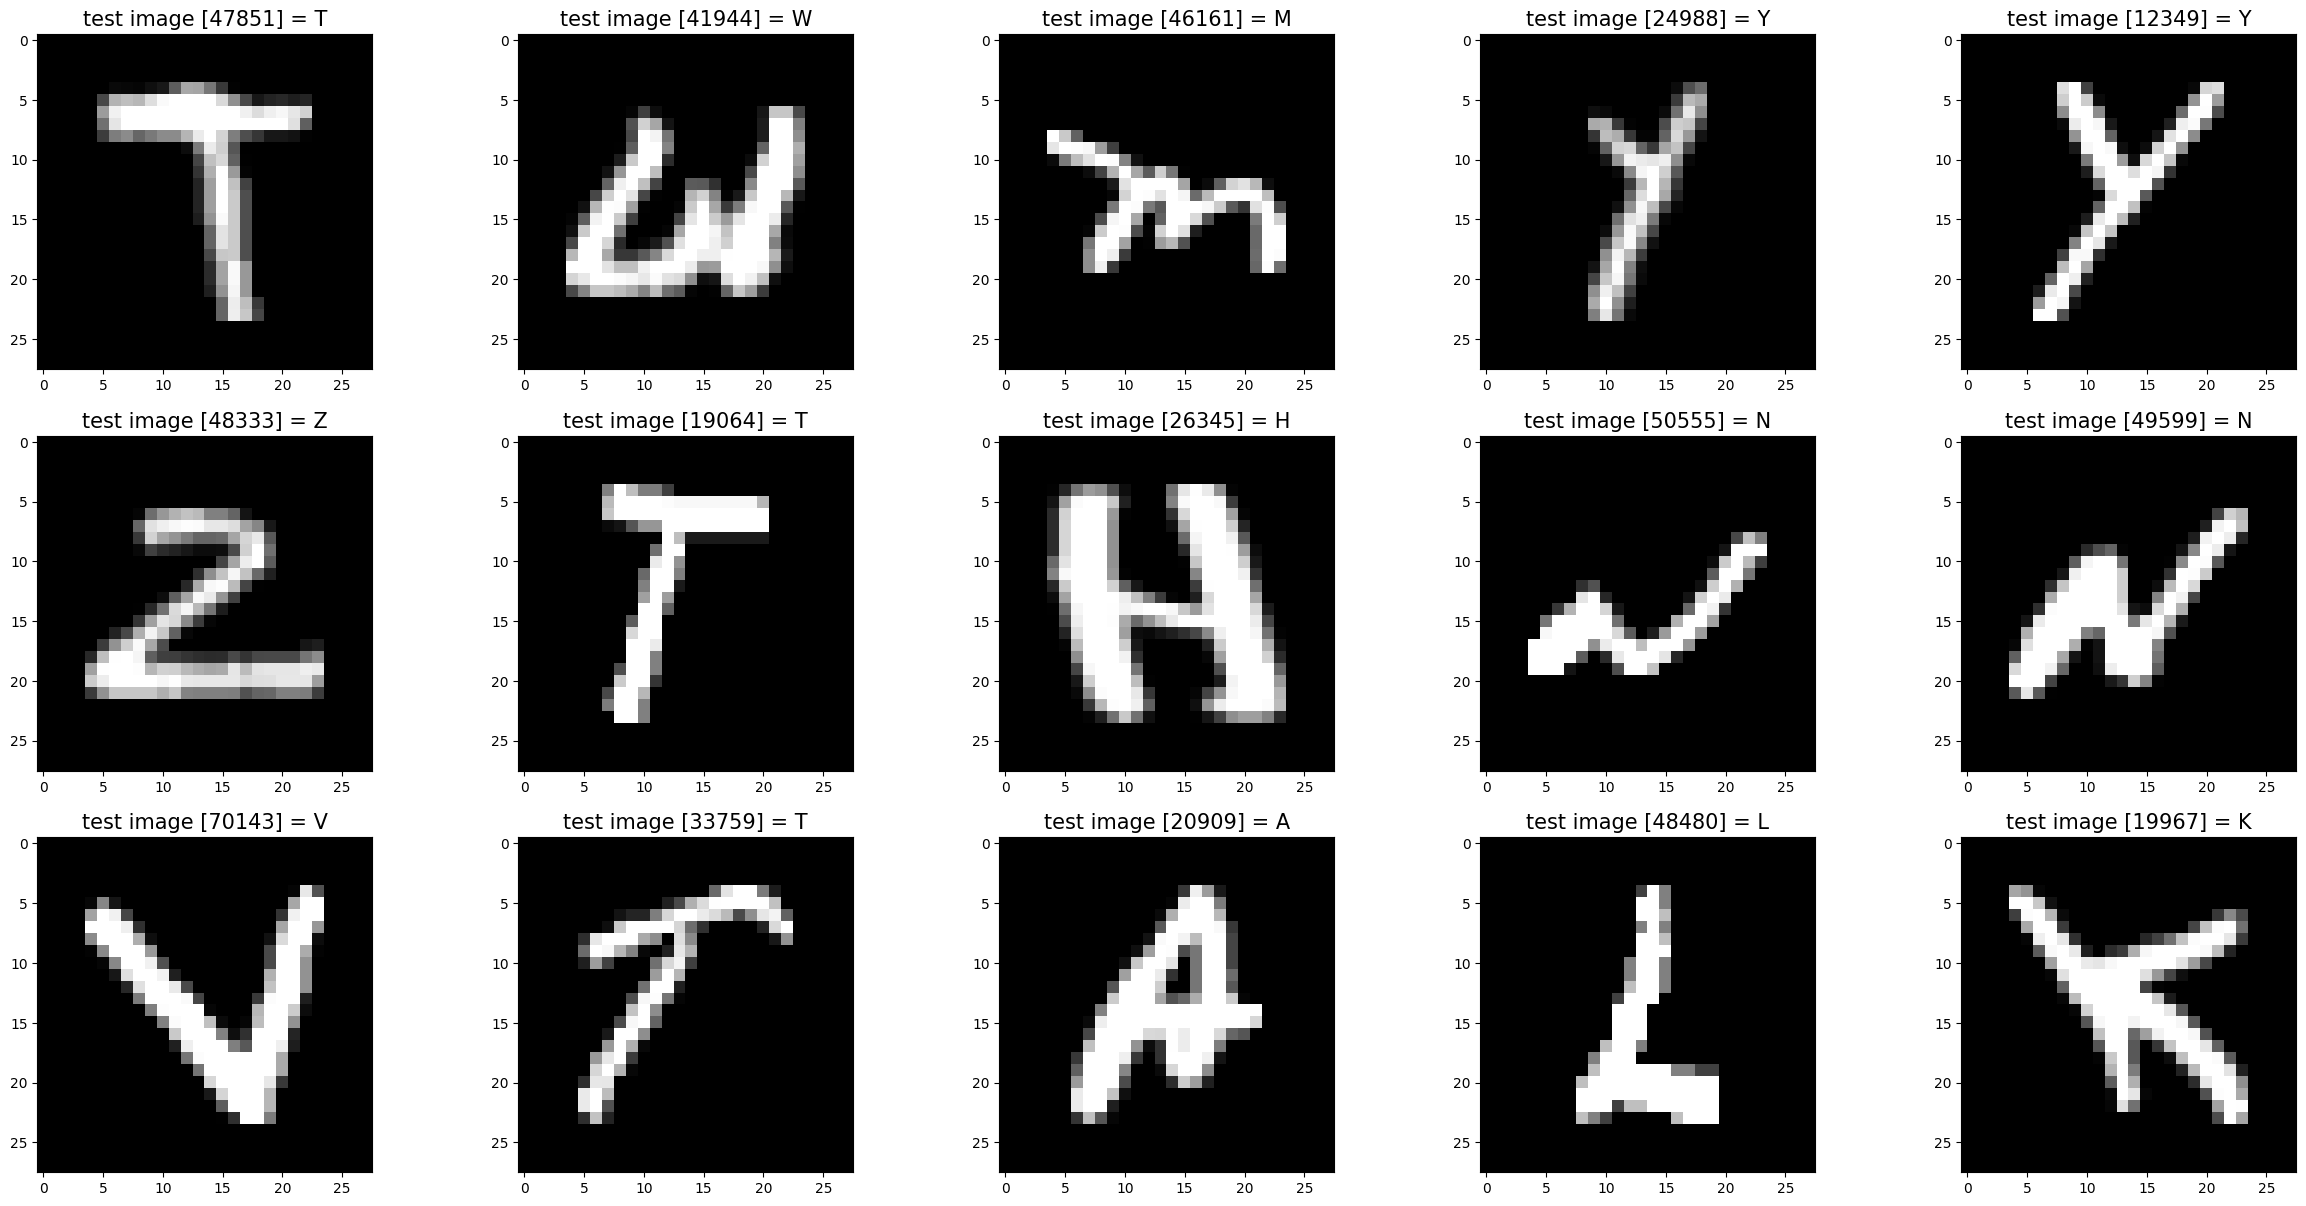

In [7]:
# Show some random test images
#
images_2_show = []
titles_2_show = []
test_sample = np.random.choice(range(len(y_test)), size=15)
for r in test_sample:
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + letters.labels[y_test[r]])

show_images(images_2_show, titles_2_show)

(15, 28, 28, 1)
(15, 28, 28, 1)


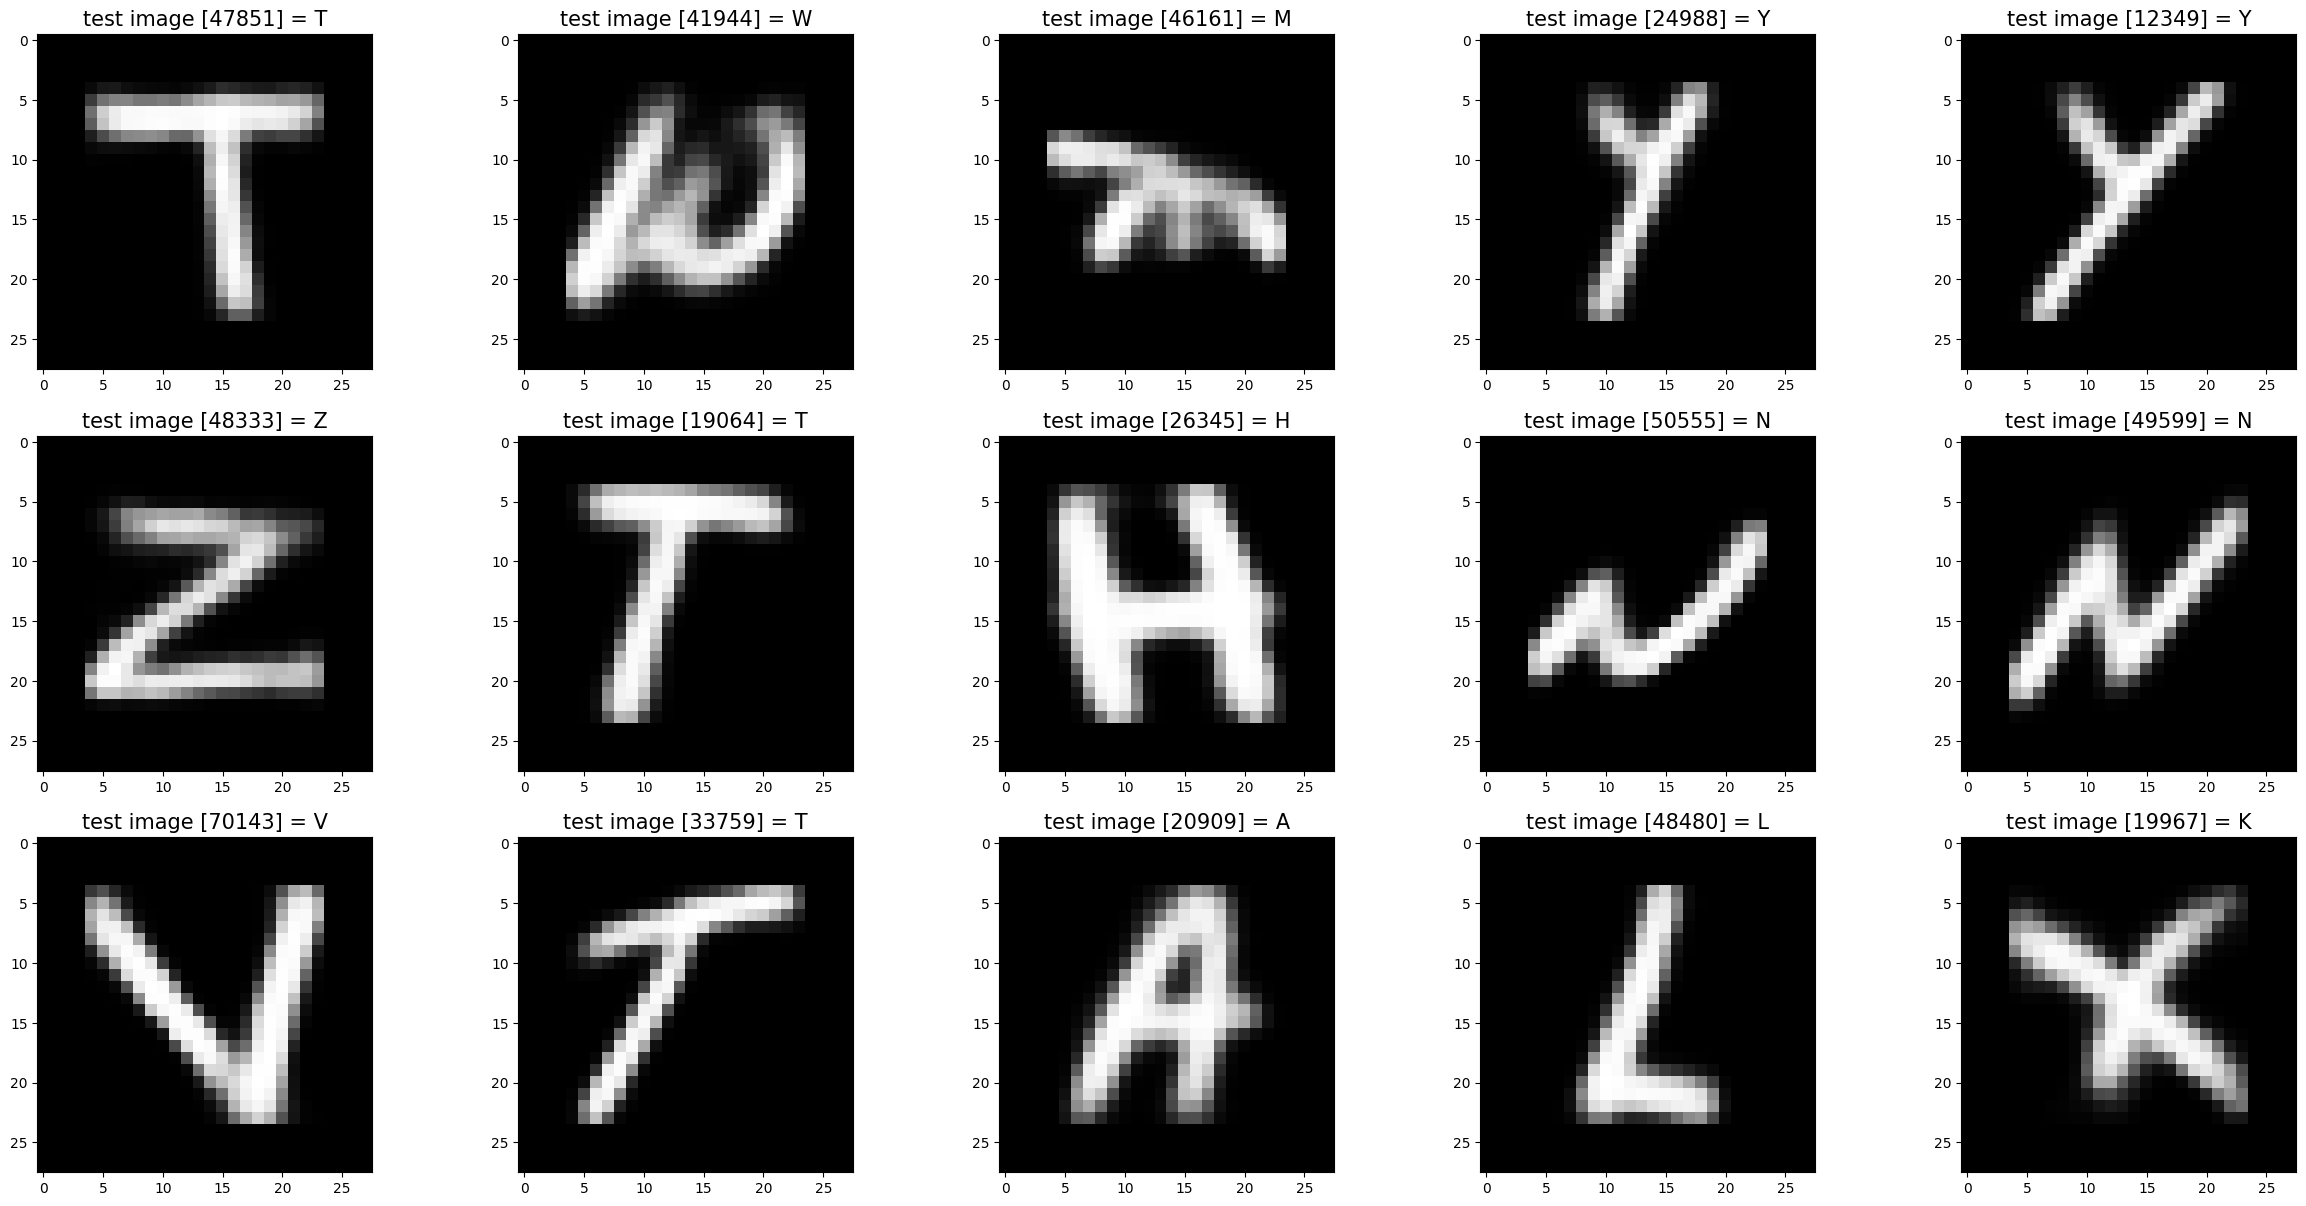

In [8]:
# Use trained VAE to predict samples selected above
#
images_2_show = []
titles_2_show = []

x_decoded, _ = model.predict(letters.normalize(x_test[test_sample]), verbose=0)
print(x_decoded.shape)
x_decoded = letters.inverse_transform(x_decoded)
print(x_decoded.shape)

for i, r in enumerate(test_sample):
    images_2_show.append(x_decoded[i].reshape(mnist_letters.shape[1:3]))
    titles_2_show.append('test image [' + str(r) + '] = ' + letters.labels[y_test[r]])

show_images(images_2_show, titles_2_show)

In [9]:
# Load MNIST digit dataset
#
input_path = '../input/mnist-dataset'

digits = MNIST_digits(input_path)
(x_train_, y_train_), (x_test_, y_test_) = digits.load_data()

select1 = (y_train_==1) | (y_train_==7) | (y_train_==4)
select2 = (y_test_==1) | (y_test_==7) | (y_test_==4)
x_train_, y_train_ = x_train_[select1], y_train_[select1]
x_test_, y_test_ = x_test_[select2], y_test_[select2]
mnist_digits = np.concatenate([x_train_, x_test_], axis=0)
mnist_labels = np.concatenate([y_train_, y_test_])

print("Dimension of mnist_digits: {:<15}".format(str(mnist_digits.shape)))
print("Dimension of mnist_labels: {:<15}".format(str(mnist_labels.shape)))

Dimension of mnist_digits: (21994, 28, 28)
Dimension of mnist_labels: (21994,)       


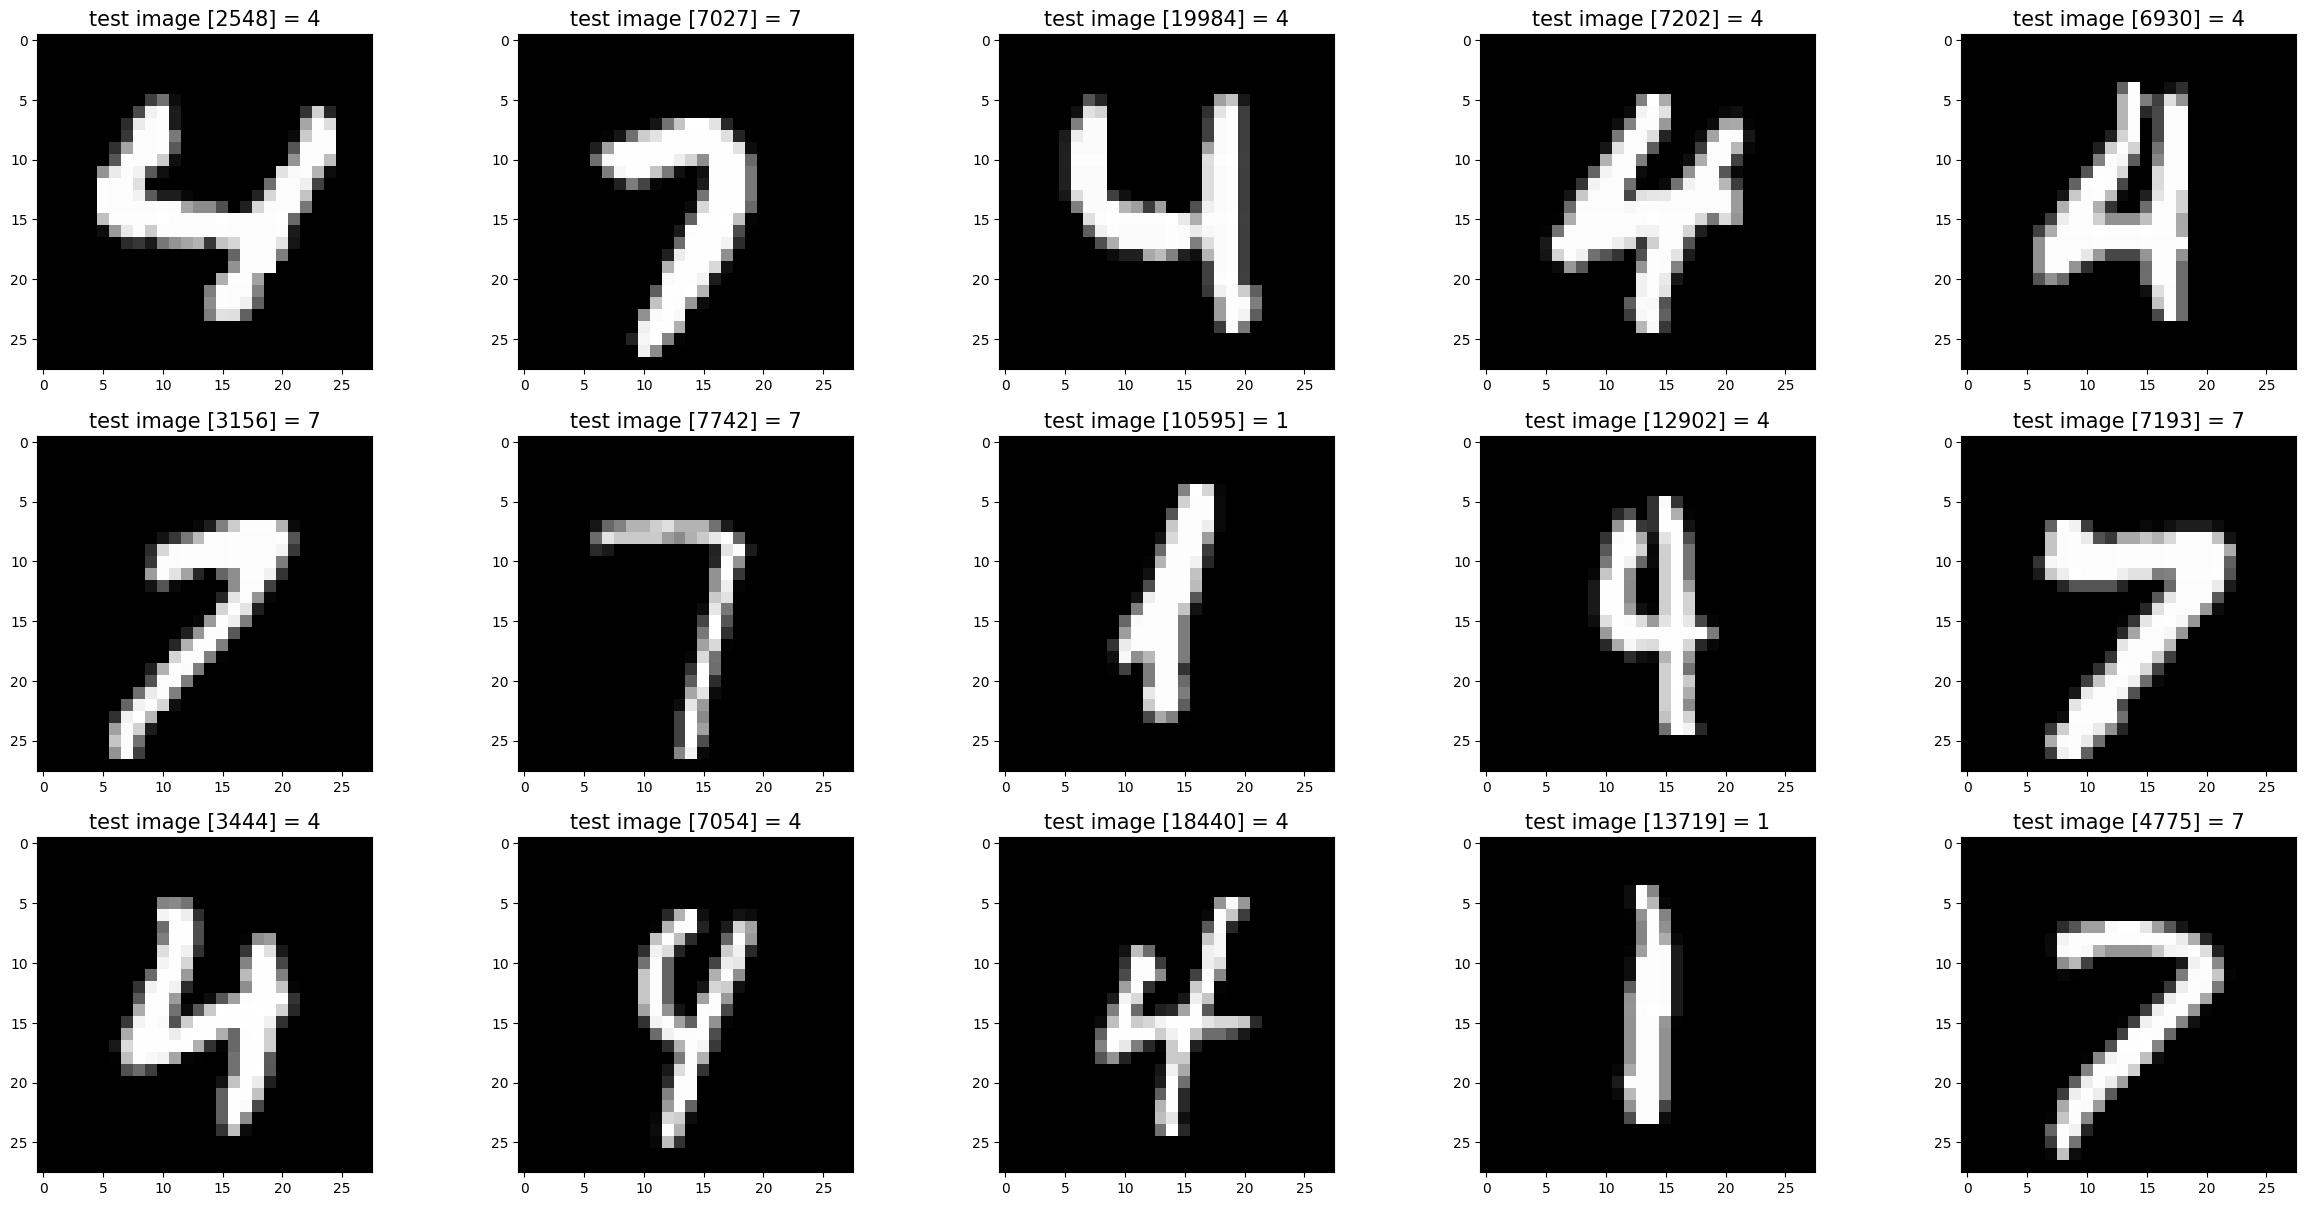

In [10]:
# Show some random test images
#
images_2_show = []
titles_2_show = []
test_sample2 = np.random.choice(range(len(mnist_labels)), size=15)
for r in test_sample2:
    images_2_show.append(mnist_digits[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(mnist_labels[r]))

show_images(images_2_show, titles_2_show)

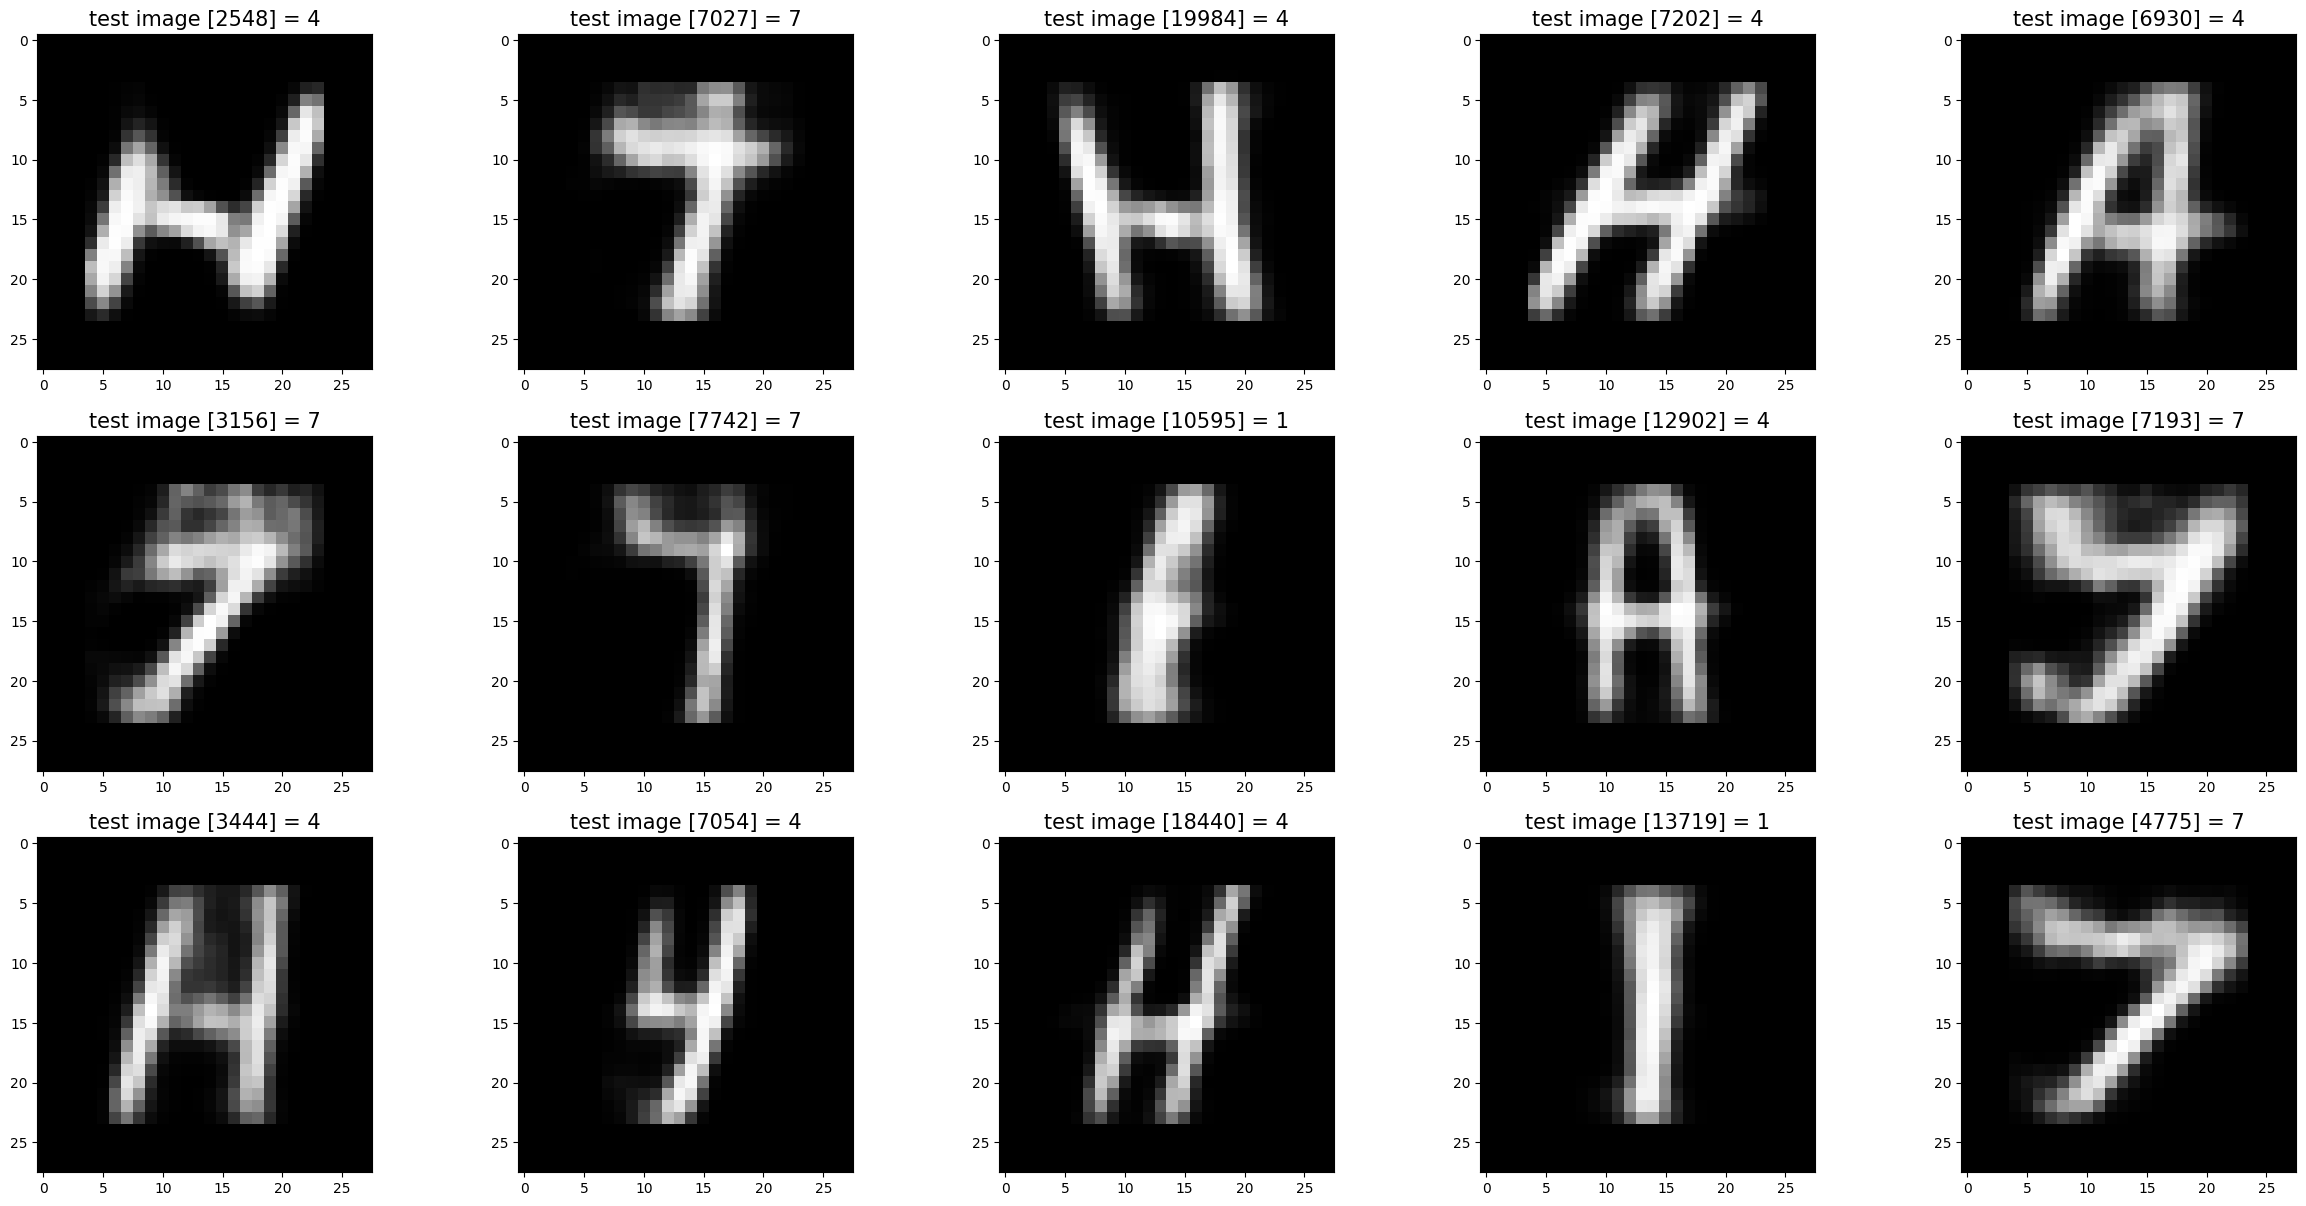

In [11]:
# Use trained VAE to predict samples selected above
#
images_2_show = []
titles_2_show = []

x_decoded, _ = model.predict(letters.normalize(mnist_digits[test_sample2]), verbose=0)
x_decoded = letters.inverse_transform(x_decoded)
img_shape = x_decoded[0].shape[:2]
for i, r in enumerate(test_sample2):
    images_2_show.append(x_decoded[i].reshape(img_shape))
    titles_2_show.append('test image [' + str(r) + '] = ' + str(mnist_labels[r]))

show_images(images_2_show, titles_2_show)

### 4. AE (non-variational)

In [12]:
model2 = AE_variational(in_shape=mnist_letters.shape[1:], panel_size=[32,64],
                       latent_dim=32, ARCH_NN='auto')
model2.encoder.summary()
model2.decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 Conv2D_1 (Conv2D)           (None, 28, 28, 32)           320       ['inputs[0][0]']              
                                                                                                  
 encode_1 (MaxPooling2D)     (None, 14, 14, 32)           0         ['Conv2D_1[0][0]']            
                                                                                                  
 Conv2D_0 (Conv2D)           (None, 14, 14, 64)           18496     ['encode_1[0][0]']            
                                                                                            

### Train AE

In [13]:
callback = keras.callbacks.EarlyStopping(
    monitor="val_reconstruction_loss",
    patience=10,
    verbose=1,
    restore_best_weights=True
)

model2.compile(optimizer=keras.optimizers.Adam())
if TRAIN_MODEL:
    history = model2.fit(
        mnist_letters,
        mnist_letters,
        epochs=100,
        batch_size=128,
        callbacks=[callback],
        validation_split=0.2,
        verbose=0
    )
    # model2.save('model.keras')
    model2.save_weights('/kaggle/working/checkpoints/last_checkpoint')
else:
    # model2 = keras.models.load_model('model.keras')
    model2.load_weights('/kaggle/working/checkpoints/last_checkpoint')


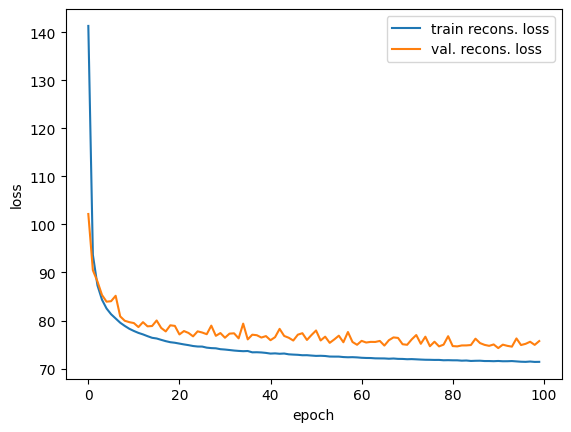

In [14]:
# plot history
if TRAIN_MODEL:
    plt.plot(history.history['reconstruction_loss'], label='train recons. loss')
    plt.plot(history.history['val_reconstruction_loss'], label='val. recons. loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

### AE Predictions

(15, 28, 28, 1)
(15, 28, 28, 1)


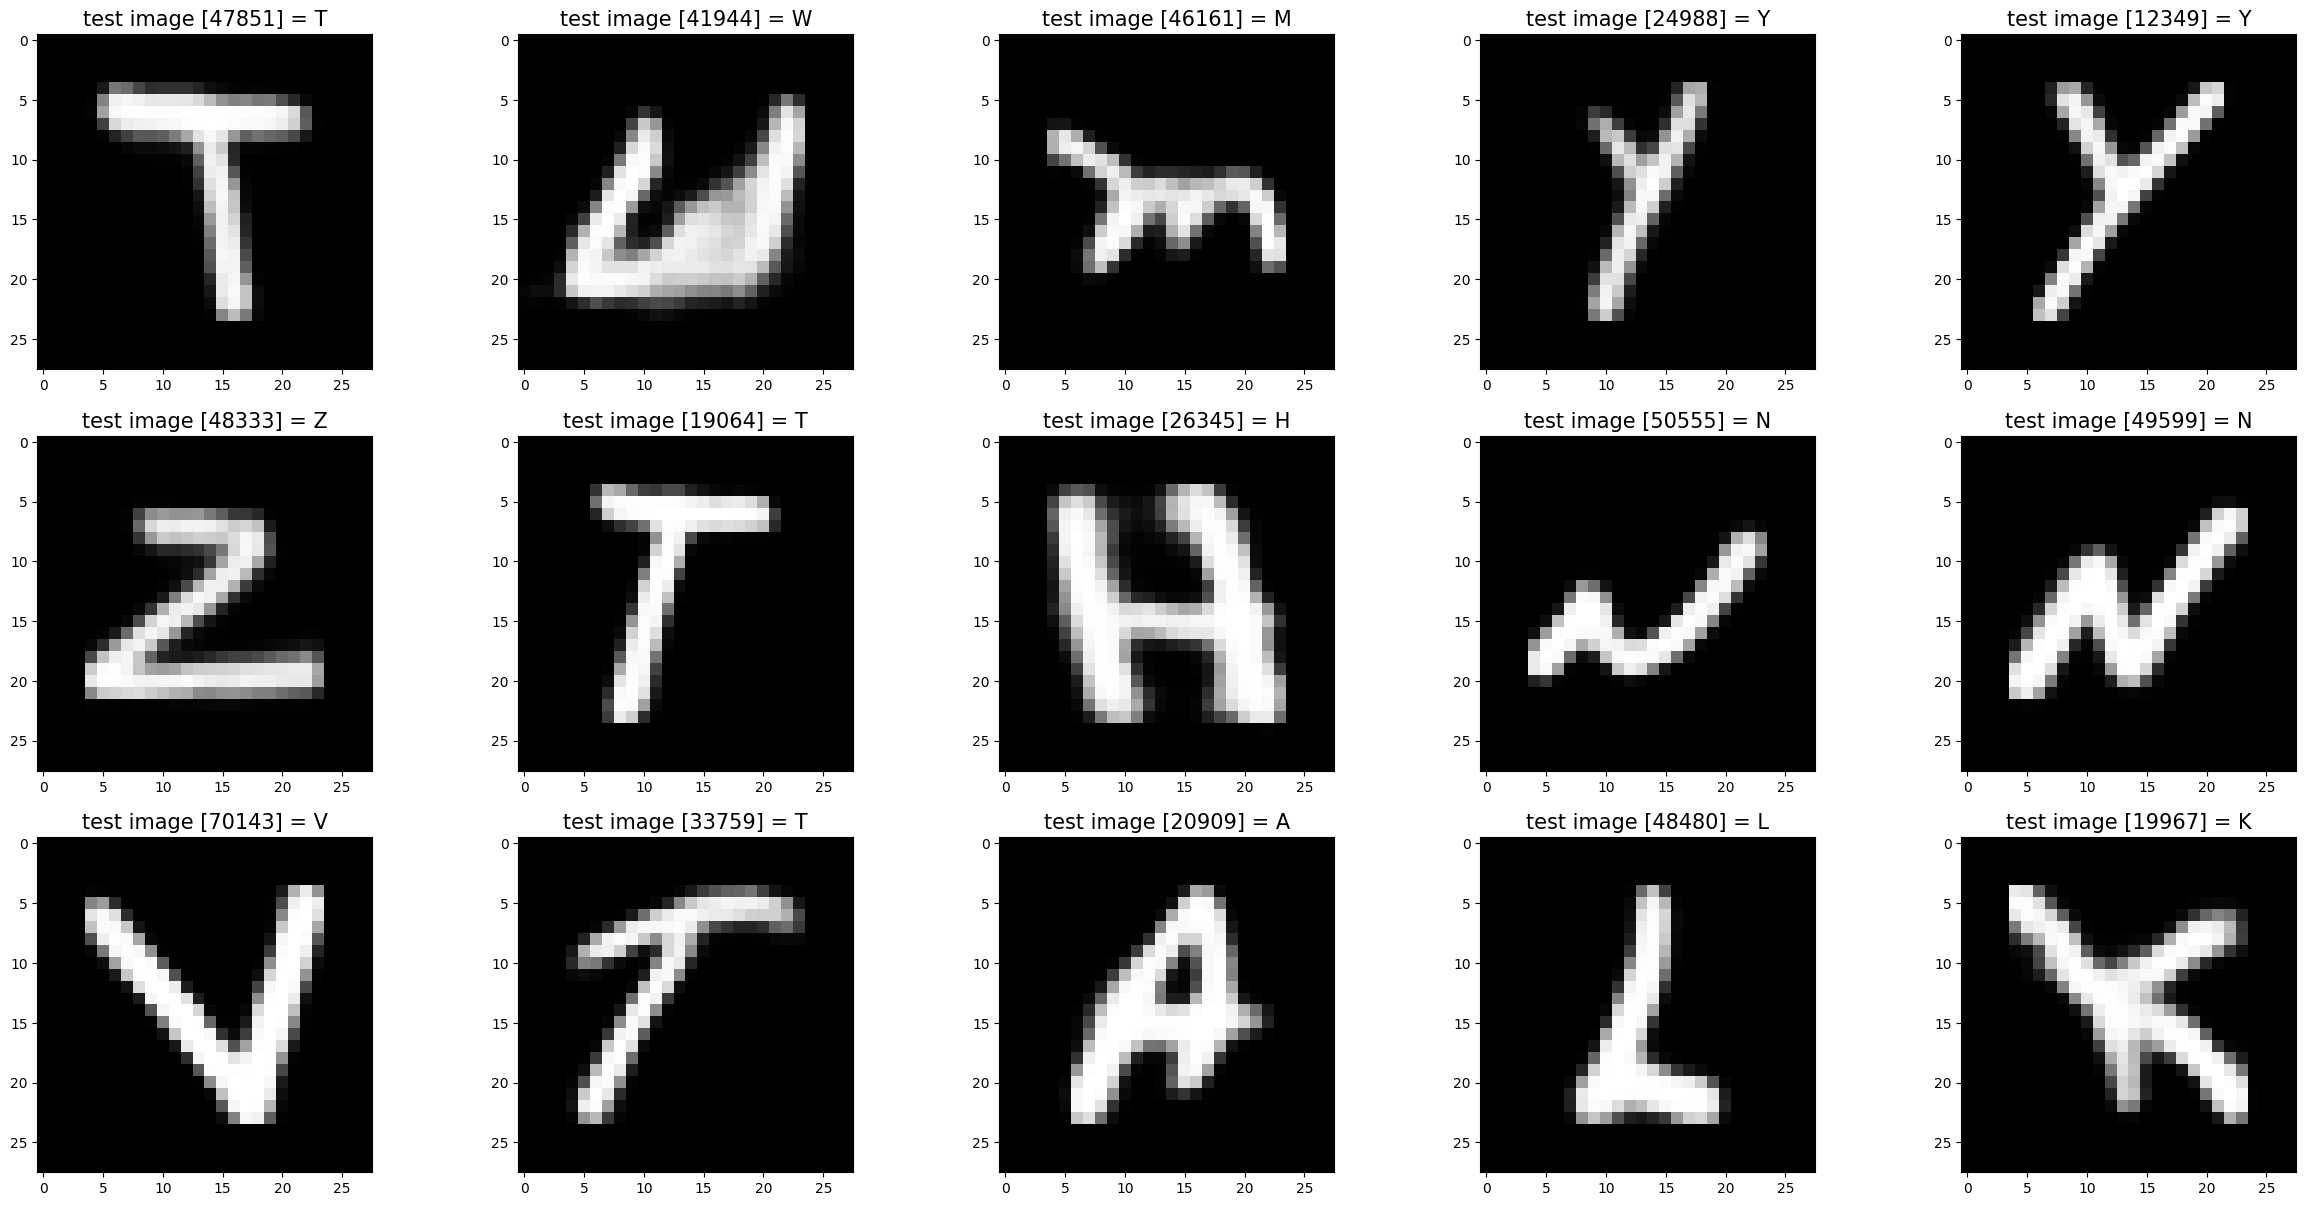

In [15]:
# Use trained VAE to predict samples selected above
#
images_2_show = []
titles_2_show = []

x_decoded, _ = model2.predict(letters.normalize(x_test[test_sample]), verbose=0)
print(x_decoded.shape)
x_decoded = letters.inverse_transform(x_decoded)
print(x_decoded.shape)

for i, r in enumerate(test_sample):
    images_2_show.append(x_decoded[i].reshape(mnist_letters.shape[1:3]))
    titles_2_show.append('test image [' + str(r) + '] = ' + letters.labels[y_test[r]])

show_images(images_2_show, titles_2_show)

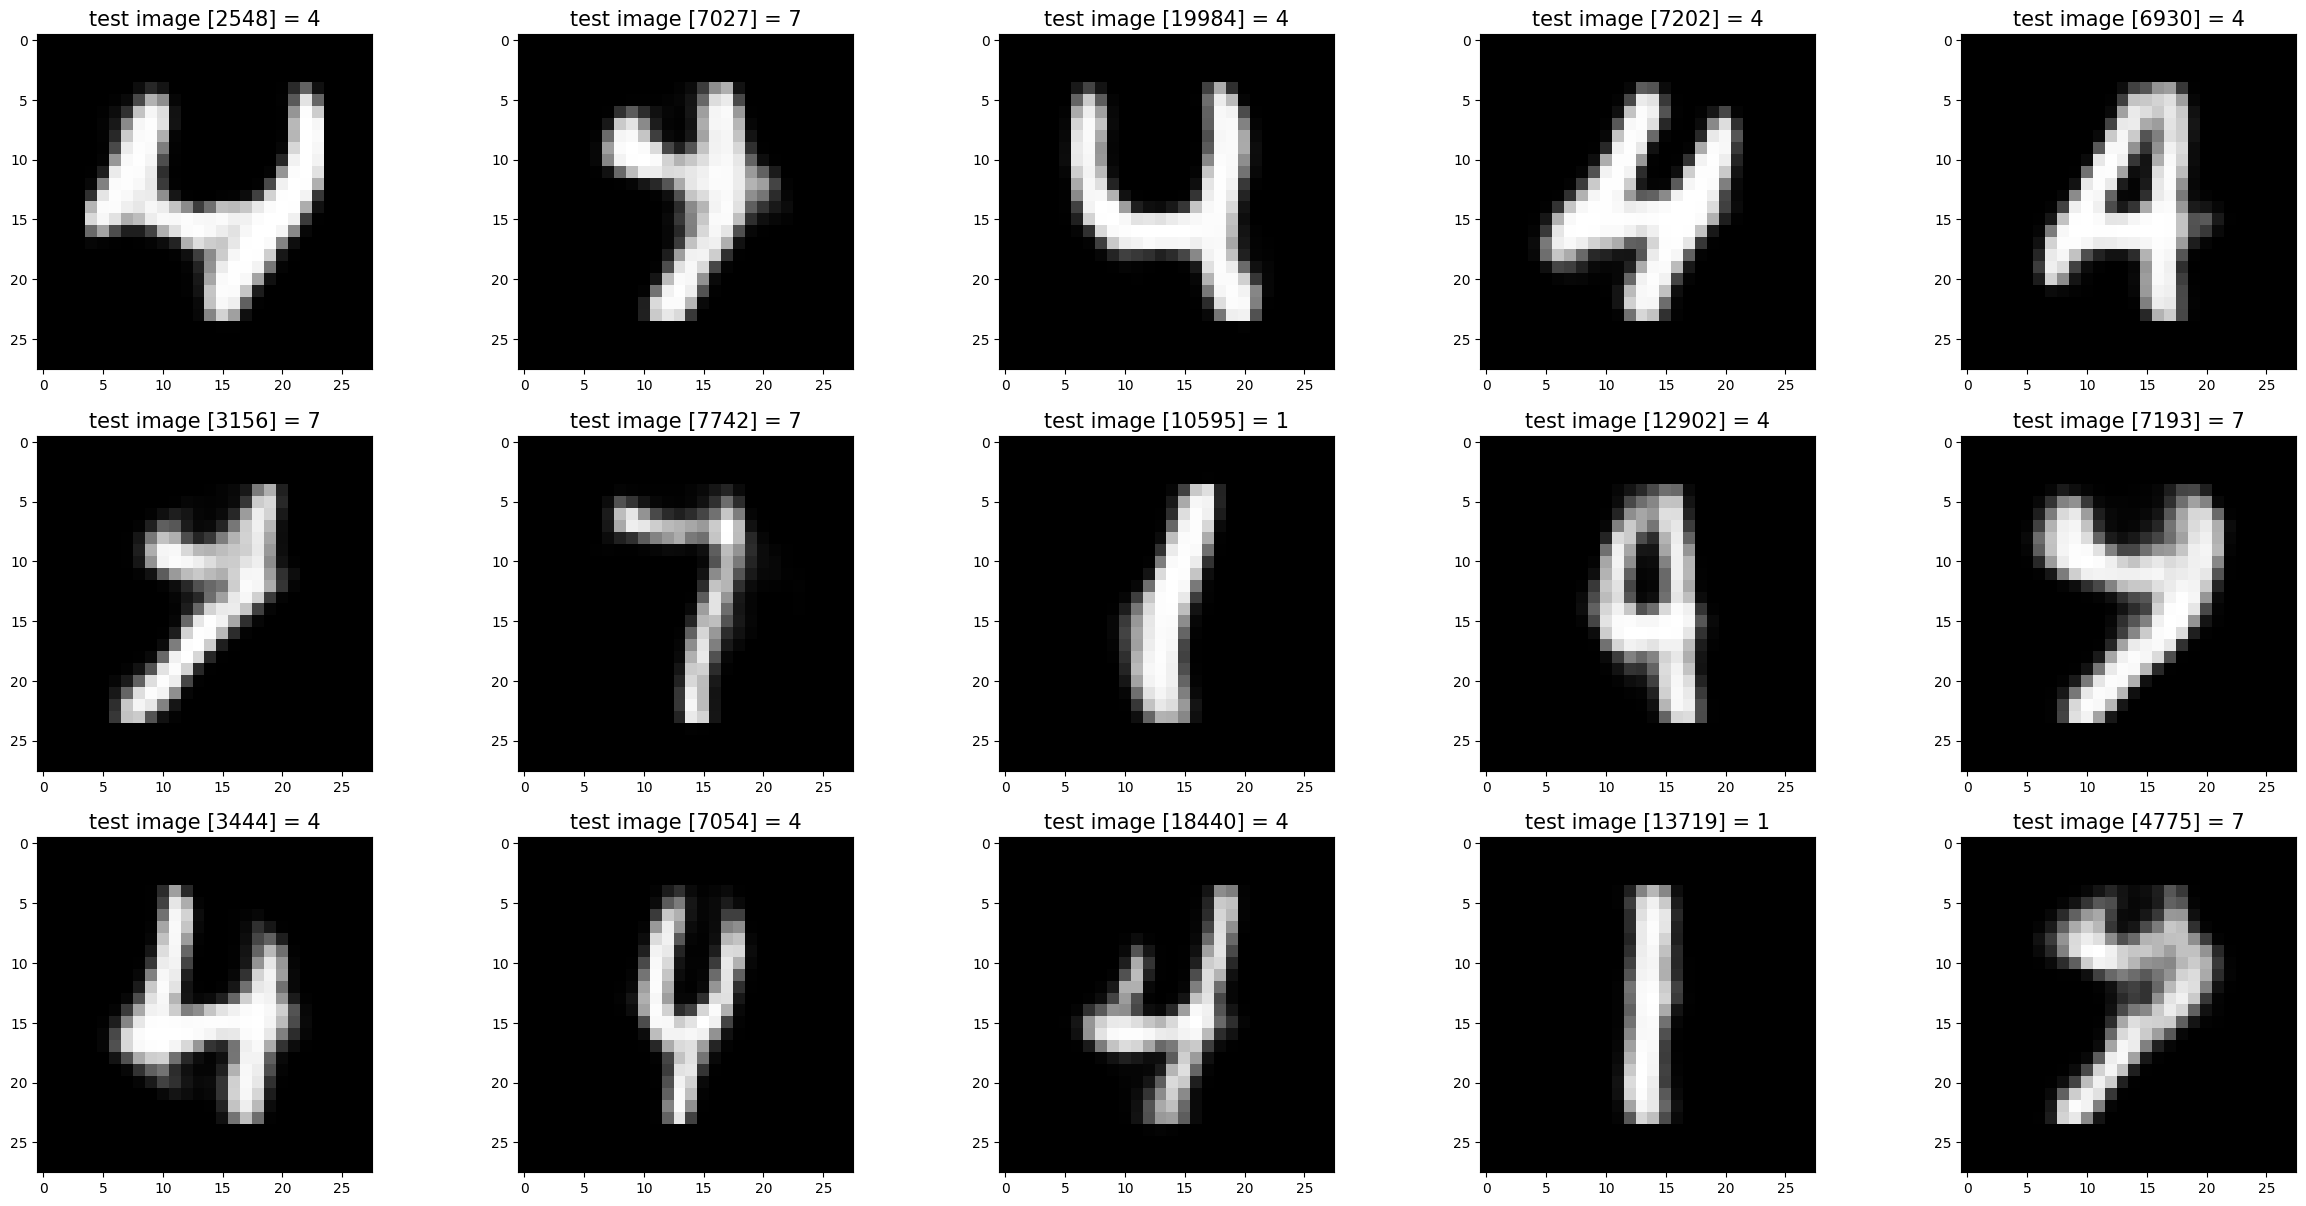

In [16]:
# Use trained VAE to predict samples selected above
#
images_2_show = []
titles_2_show = []

x_decoded, _ = model2.predict(letters.normalize(mnist_digits[test_sample2]), verbose=0)
x_decoded = letters.inverse_transform(x_decoded)
img_shape = x_decoded[0].shape[:2]
for i, r in enumerate(test_sample2):
    images_2_show.append(x_decoded[i].reshape(img_shape))
    titles_2_show.append('test image [' + str(r) + '] = ' + str(mnist_labels[r]))

show_images(images_2_show, titles_2_show)